# Validity prediction

## Description / Goal

Goal: Create a validity predictive model to predict the validity of a simulation for an approximation rate thanks to features (here geomorphological features of the geographical site) regarding that simulation.




## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import random
random.seed(42)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier

## Functions to load 

In [3]:
def add_validity_feature_from_validation_metric(df_data, validity_threshold):
    df_data["Validity"] = np.where(df_data["Validation Metric"] > validity_threshold, 0, 1)
    return df_data

In [4]:
def retrieve_list_cases_and_split_data_BVE(data_complete, sites_completes, ratio_train):
    #Computing the number of sites that are used for the training
    training_nb_cases = round(len(sites_completes) * ratio_train)

    # Selecting the sites for the training and testing sets randomly 
    training_cases = random.sample(sites_completes.tolist(), training_nb_cases)
    testing_cases = [x for x in sites_completes.tolist() if x not in training_cases]
    
    # Retrieving the dataset for the training phase
    data_train = extract_data_from_list_of_sites(data_complete, training_cases)
    
    # Retrieving the dataset for the testing phase
    data_test = extract_data_from_list_of_sites(data_complete, testing_cases)

    return data_train, data_test, training_cases, testing_cases

In [5]:
def extract_data_from_list_of_sites(data_complete, cases):
    data_cases = pd.DataFrame(columns=data_complete.columns)
    for case in cases:
        data_case = data_complete.loc[(data_complete['SiteNumber'] == case)]
        data_cases = pd.concat([data_cases, data_case], sort=False)
        
    return data_cases

In [6]:
def extract_features_and_outputs_datasets_BVE(data_train, data_test, features):
    # load names of all the features contained in the dataset to extract the data we want from
    global all_features
    
    X_train, y_train = create_input_and_output_datasets_for_validity(data_train)
    X_test, y_test = create_input_and_output_datasets_for_validity(data_test)
    
    
    features_to_remove = [feature for feature in all_features if feature not in features]
    for feature in features_to_remove:
        del X_train[str(feature)]
        del X_test[str(feature)]

    return X_train, y_train, X_test, y_test 

In [7]:
def create_input_and_output_datasets_for_validity(data):
    y_data = data.filter(["SiteNumber", "Validity"], axis=1)
    X_data = data.drop(["Chronicle", "Validation Metric", "Accuracy", "Time", "Validity"], axis=1)
    del y_data["SiteNumber"]
    del X_data["SiteNumber"]
    return X_data, y_data

In [8]:
from sklearn import metrics

def compute_score(y_test, y_test_pred):
    acc_score = metrics.accuracy_score(y_test.values.ravel().astype(int), y_test_pred)
    return acc_score

In [9]:
def update_and_store_data_with_validity_pred(path, data_test, y_test, y_test_pred, testing_cases):
    suffixe = "_".join(map(str,list(map(int, sorted(testing_cases)))))
    data_test = data_test.assign(Validitytest=y_test.values.ravel())
    data_test = data_test.assign(ValidityPred=y_test_pred)
    data_test.to_csv(os.path.join(path,"data/Output_Data/Data_Test_With_Validity_pred_Rates_" + str(nb_rates) + "_Features_" + str('_'.join(features)) + "_" + str(scale)  + "_" + str(suffixe) + ".csv"), index=False, sep=";")
    return data_test

# Evaluation Pipeline

## Parameters

In [10]:
path = os.path.abspath(os.path.join(os.path.abspath(""), os.pardir))
nb_rates = 30
chronicle = 0
scale = "BVE"
ratio_train = 0.8
validity_threshold = 0.1
k=3

# Different sets of features 
set_geomorph = ["Slope", "Elevation", "LC", "CW", "Area"]
set_CVHV = ["Coastal Vulnerability", "Hydrological Vulnerability"]
set_saturation= ["Satured Zone Area", "Vulnerability Sum", "Vulnerability Rate"]
set_cells = ["Number of Cells"]
all_features = set_geomorph + set_CVHV + set_saturation + set_cells

# We select the type of features we want to use for training our model
features = set_geomorph

## Pipeline

In [14]:
def pipeline_pred_validity(path, nb_rates, features, scale, ratio_train):
    df_data = pd.read_csv(os.path.join(path, "data/", "Input_Data_Time_ValidMetric_Features_Rates_" + str(nb_rates) + "_Features_" + "Geomorph_CVHV_Saturation_Cells" + "_" + str(scale) + "_Comparable.csv"), sep=";")
    #data_complete = extract_complete_data_for_BVE(df_data)
    sites_completes = df_data.SiteNumber.unique()
    df_data = add_validity_feature_from_validation_metric(df_data, validity_threshold)
    data_train, data_test, training_cases, testing_cases = retrieve_list_cases_and_split_data_BVE(df_data, sites_completes, ratio_train)
    X_train, y_train, X_test, y_test = extract_features_and_outputs_datasets_BVE(data_train, data_test, features)
    global k
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train.values.ravel().astype(int))
    y_test_pred = classifier.predict(X_test)
    acc_score = compute_score(y_test, y_test_pred)
    print("Accuracy Score:", acc_score)
    data_test = update_and_store_data_with_validity_pred(path, data_test, y_test, y_test_pred, testing_cases)
    return acc_score

    

## Replication of elaboration of the validity predictive model : x 25

In [15]:
scores_acc = []
for i in range(25):
    print("Replication:", i+1)
    acc_score = pipeline_pred_validity(path, nb_rates, features, scale, ratio_train)
    scores_acc.append(acc_score)
    print("----------")

Replication: 1
Accuracy Score: 0.9133333333333333
----------
Replication: 2
Accuracy Score: 0.9066666666666666
----------
Replication: 3
Accuracy Score: 0.9133333333333333
----------
Replication: 4
Accuracy Score: 0.8866666666666667
----------
Replication: 5
Accuracy Score: 0.84
----------
Replication: 6
Accuracy Score: 0.8666666666666667
----------
Replication: 7
Accuracy Score: 0.78
----------
Replication: 8
Accuracy Score: 0.8733333333333333
----------
Replication: 9
Accuracy Score: 0.8466666666666667
----------
Replication: 10
Accuracy Score: 0.8933333333333333
----------
Replication: 11
Accuracy Score: 0.8066666666666666
----------
Replication: 12
Accuracy Score: 0.9133333333333333
----------
Replication: 13
Accuracy Score: 0.9133333333333333
----------
Replication: 14
Accuracy Score: 0.7733333333333333
----------
Replication: 15
Accuracy Score: 0.8733333333333333
----------
Replication: 16
Accuracy Score: 0.8866666666666667
----------
Replication: 17
Accuracy Score: 0.83333333333

## Statistics of scores

### Accuracy

In [16]:
import statistics
print("Mean:", statistics.mean(scores_acc), ", Median:", statistics.median(scores_acc))
print("Min:", min(scores_acc), ", Max:", max(scores_acc), ", Std:", statistics.stdev(scores_acc))

Mean: 0.8693333333333333 , Median: 0.88
Min: 0.7733333333333333 , Max: 0.9533333333333334 , Std: 0.05106277908033803


## Plotting the scores

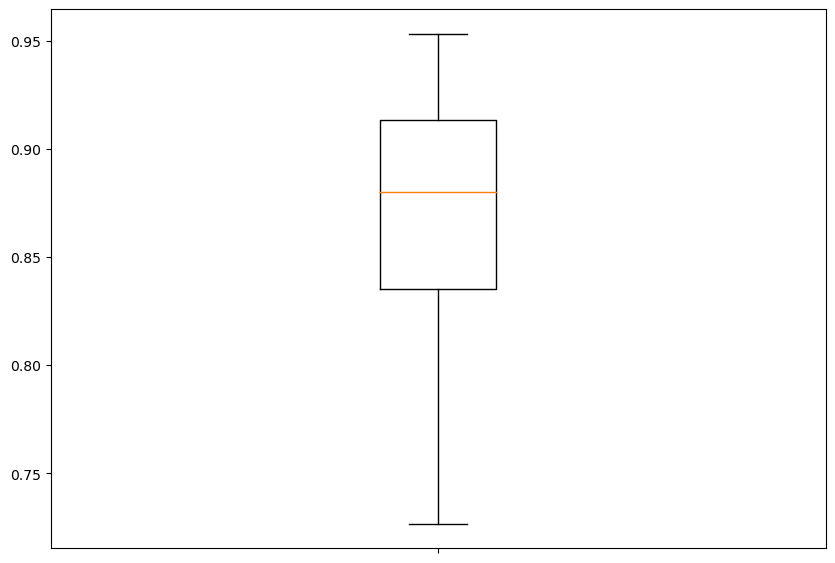

In [13]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(scores_acc)
plt.xticks([1], [""])
 
# show plot
#plt.show()
plt.savefig('Validity_Acc_25Repetitions.pdf')

### 